  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ShopifyAPI: filename=shopifyapi-12.7.0-py3-none-any.whl size=46906 sha256=c0730613f88ea1ab51ce96a25ef3016926567a36c1c24278bc9d6c829f441cf2
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\f1\fc\97\504dfeaa97b4b5229b009526df5e8ce27b9a4156391d9bca3b
  Created wheel for pyactiveresource: filename=pyactiveresource-2.2.2-py3-none-any.whl size=23337 sha256=1c56ed5b480542014964e4cf94d8a1d51676898eb65be1fa58b2e0638a3ce69c
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\71\7d\bf\59e66200be3cbace

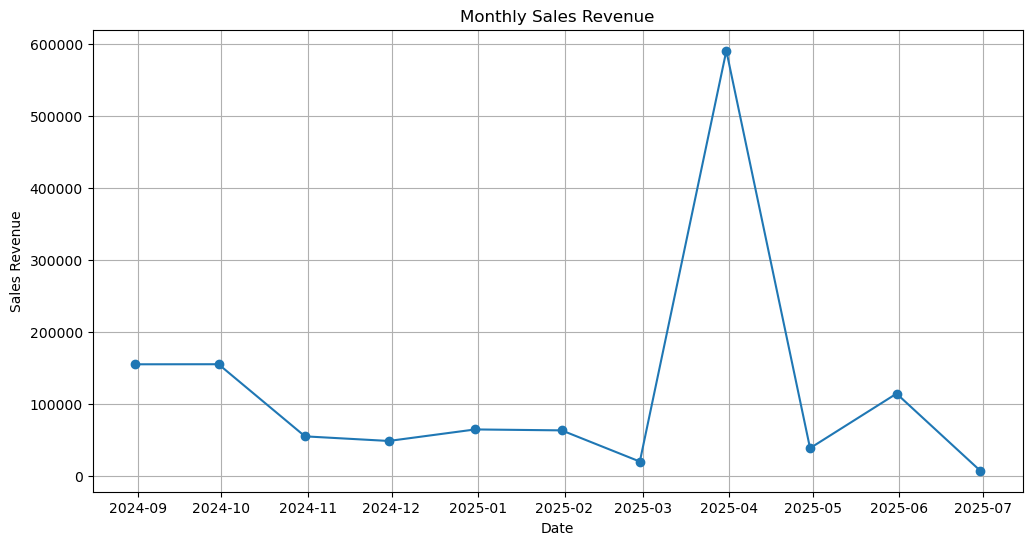

15:22:27 - cmdstanpy - INFO - Chain [1] start processing
15:22:27 - cmdstanpy - INFO - Chain [1] done processing


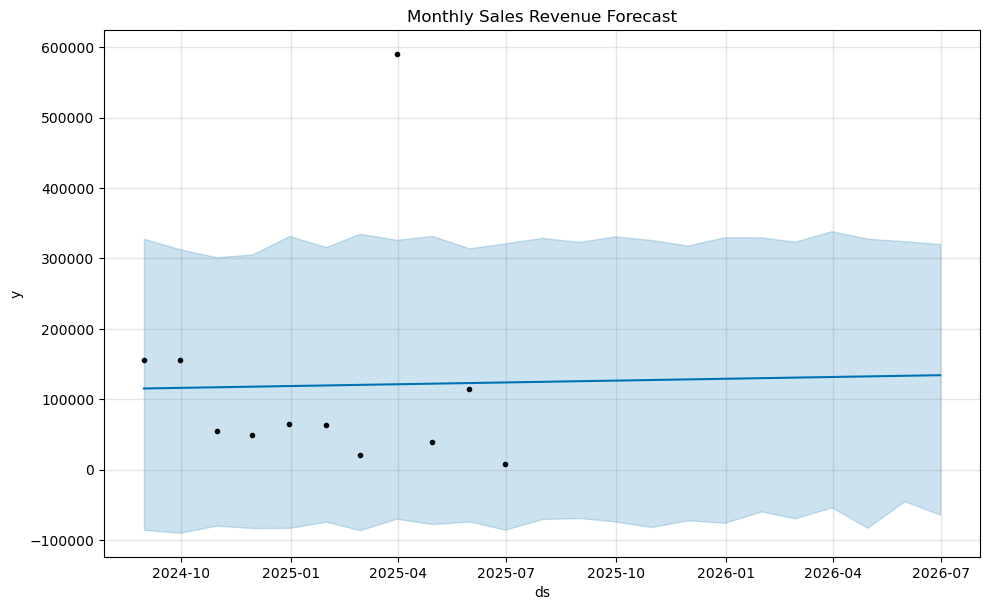

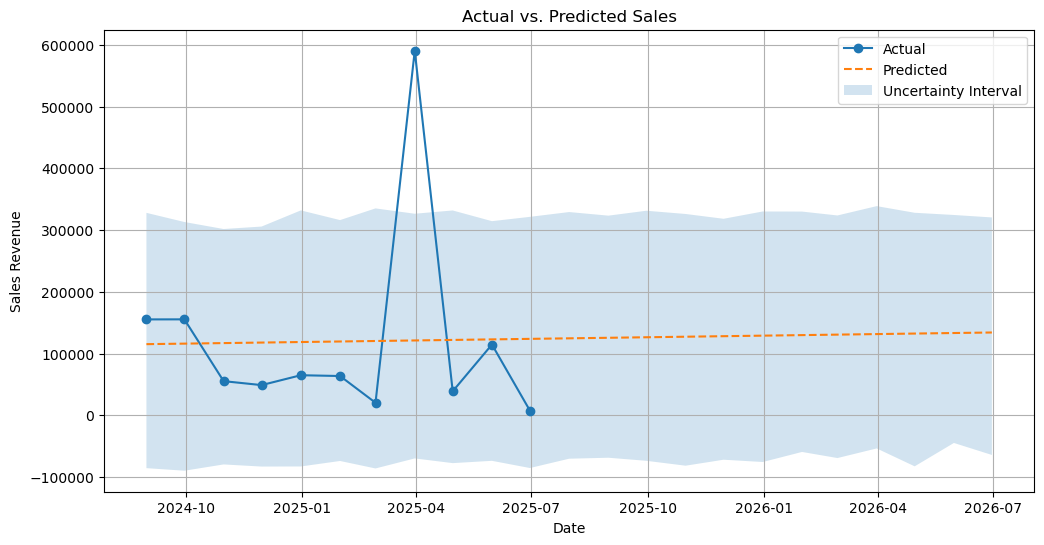

Mean Absolute Error (MAE): 99677.97


In [ ]:
!pip install ShopifyAPI
!pip install prophet

# Import necessary libraries
import shopify  # Shopify API interaction
import pandas as pd  # Data handling
import matplotlib.pyplot as plt  # Data visualization
from prophet import Prophet  # Time series forecasting model
from sklearn.metrics import mean_absolute_error  # Model evaluation metric

# ----------------------------- Step 1: Extract Data from Shopify -----------------------------

# Shopify API setup
shop_url = "https://star-lawn-aru.myshopify.com/admin"  # Your Shopify store URL
api_version = "2023-07"  # Shopify API version
api_key = "4c88c63********4241eb8b1af"  # Replace with  API key
password = "shpat_297c5******14b613f42f64be98bb"  # Replace with  API password

# Initialize Shopify session
shopify.Session.setup(api_key=api_key, secret=password)  # Set up the session
session = shopify.Session(shop_url, api_version, password)  # Create session
shopify.ShopifyResource.activate_session(session)  # Activate session

# Fetch orders (max 250 records)
orders = shopify.Order.find(limit=250)

# Extract required fields from orders
data = []
for order in orders:
    data.append({
        "created_at": order.created_at,  # Order date
        "total_price": float(order.total_price)  # Total order value
    })

# Create DataFrame from order data
df = pd.DataFrame(data)
df['created_at'] = pd.to_datetime(df['created_at'])  # Ensure date column is datetime format

# ----------------------------- Step 2: Data Preparation -----------------------------

# Check for missing values
print("Checking for missing values:")
print(df.isnull().sum())  # Print null count per column

# Remove any rows with missing values
df.dropna(inplace=True)

# Aggregate sales by month
monthly_sales = df.resample('M', on='created_at').sum().reset_index()  # Monthly total
monthly_sales.rename(columns={'total_price': 'monthly_sales'}, inplace=True)  # Rename column

# Plot monthly sales trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['created_at'], monthly_sales['monthly_sales'], marker='o')
plt.title('Monthly Sales Revenue')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.grid(True)
plt.show()

# ----------------------------- Step 3: Build Forecast Model -----------------------------

# Prepare data for Prophet model
prophet_data = monthly_sales[['created_at', 'monthly_sales']].rename(columns={'created_at': 'ds', 'monthly_sales': 'y'})
prophet_data['ds'] = pd.to_datetime(prophet_data['ds']).dt.tz_localize(None)  # Remove timezone

# Initialize and train the Prophet model
model = Prophet()
model.fit(prophet_data)

# ----------------------------- Step 4: Make Future Predictions -----------------------------

# Create future date range (12 months ahead)
future = model.make_future_dataframe(periods=12, freq='M')

# Predict future sales
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Monthly Sales Revenue Forecast')
plt.show()

# ----------------------------- Step 5: Evaluate the Model -----------------------------

# Plot actual vs. predicted sales
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(prophet_data['ds'], prophet_data['y'], label='Actual', marker='o')  # Actual sales
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted', linestyle='--')  # Forecast
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, label='Uncertainty Interval')
ax.set_title('Actual vs. Predicted Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Revenue')
ax.legend()
plt.grid(True)
plt.show()

# Evaluate forecast using Mean Absolute Error
actual = prophet_data['y'].values  # Ground truth
predicted = forecast['yhat'][:len(actual)].values  # Forecasted values
mae = mean_absolute_error(actual, predicted)  # Compute MAE
print(f'Mean Absolute Error (MAE): {mae:.2f}')
